数据形状: (40, 3, 32, 32)

Original input images:


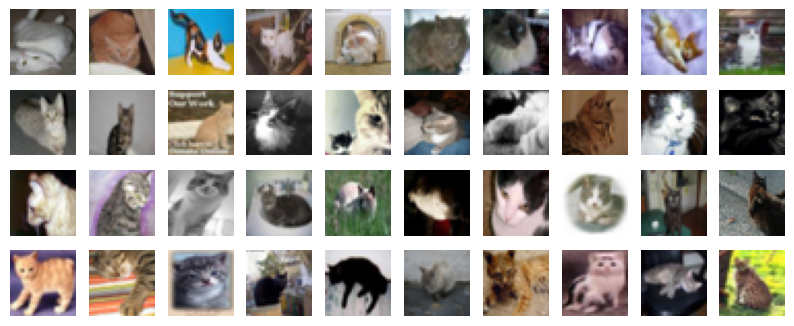

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming R is your loaded data with the shape (batch_size, 32, 32, 3)
R = np.load('/Users/jichanglong/Desktop/hssp_new/expdata/true_fl/truefl_cat/images_epoch_1_batch_0.npy')
print("数据形状:", R.shape)  # 输出应该是 (batch_size, 32, 32, 3)
R = R.transpose(0, 2, 3, 1)
# Rescale the data to the range [0, 1]
R = (R - R.min()) / (R.max() - R.min())

n =40  # Assuming you want to plot 10 images
num_col = 10  # Assuming you want 10 columns in your figure
num_row = int(n / num_col)  # Calculating the number of rows needed

shape = (32, 32,3)  # The shape of each image
fig, axes = plt.subplots(num_row, num_col, figsize=(1. * num_col, 1. * num_row))

print('\nOriginal input images:')
for i, ax in enumerate(axes.flat):
    ax.set_axis_off()
    ax.imshow(R[i].reshape(shape))
plt.savefig('./figure/true/cifar_cat_original.pdf')  # 保存为 PDF
plt.savefig('./figure/true/cifar_cat_original.png', dpi=600)  # 保存为 PNG，指定分辨率为300 dpi
plt.show()


In [19]:
load('multi-dim-hssp.sage')
load("hssp.sage")
load("extendhssp.sage")

def generate_vector(sampling_number, data, batch_size, random_sampling = False, random_generation = False, rate = 0.5, sample_figure_length = 10):
    data = np.load(data)
    if random_generation == False:
        D=matrix(ZZ,data)
        e=vector(ones_matrix(1,batch_size))
        n = batch_size
        m0 = sampling_number
        freqD=(n+1)*[0]

        for x in e*D: 
            #print(x)
            freqD[x]+=1

        freqU=[binomial(n,i)/2.**n for i in range(n+1)]

        c=dict()
        for x in D.T: 
            h=x*e
            if h in c.keys(): c[h]+=[x]
            else: c[h]=[x]
        sampleSize=[int(m0*f) for f in freqU]
        
        if random_sampling == False:
            
            L = []
    # 假设 L 是一个列表，n 和 sampleSize 已经定义
            for i in range(n + 1):
        # 先检查键 i 是否存在于字典 c 中
                if i in c:
            # 如果存在，再检查 c[i] 的长度是否大于等于 sampleSize[i]
                    if len(c[i]) >= sampleSize[i]:
                # 如果是，正常采样
                        L += random.sample(c[i], k=sampleSize[i])
                    else:
                # 如果不是，取所有元素
                        L += c[i]
        else:
            L = []
            all_elements = []
            for key, value in c.items():
                all_elements.extend(value)
    # 然后，从这个列表中随机选取100个元素，前提是列表长度至少为100
            L += random.sample(all_elements, sampling_number)
        while True:
            random.shuffle(L)
            newX=matrix(ZZ,L)
            if newX.rank()==batch_size: break 
        
        freqnewX=(n+1)*[0]
        for x in newX*e: freqnewX[x]+=1
        G1=bar_chart(freqD, legend_label='frequency hw input')
        G2=bar_chart(freqnewX, legend_label='frequency hw output')
        G3=bar_chart(freqU, legend_label='frequency hw uniform')
        #for g in [G1,G2]: g.show()
        
        
    else:
        np.random.seed(0)

        size = (sampling_number, batch_size)
        p = [rate , 1 - rate]  # 0和1出现的概率
        #print(p)
    # 使用numpy的random.choice来生成矩阵
        random_matrix = np.random.choice([0, 1], size=size, p=p)

        
        while True:
            np.random.shuffle(random_matrix)
            newX=matrix(ZZ,random_matrix)
            if newX.rank()==batch_size: break 
        
        
    m=(newX.dimensions()[0])//batch_size*batch_size
        
    l = sample_figure_length
        
    x0,A,dummyX,dummyB=genParams_mat(m=m,l=batch_size)

    Y=newX[:m]   
   
    Y = matrix(ZZ,Y)
    print(Y.dimensions())
    return Y, x0

def matrixed_image(image,batch_size):
    alp = np.load(image)
    alp = (alp + 1.0) / 2.0

    # 将像素值缩放到[0,255]的范围
    alp = (alp * 255.0).astype(np.uint8)

    # 转置维度，以便图像数据变为(batch_size, height, width, channels)
    alp = np.transpose(alp, (0, 2, 3, 1))
    alp = alp.reshape(batch_size, -1)

    # alp=np.load("/Users/jichanglong/Desktop/hssp_All/quantize/alpha10_3072.npy")
    # print(alp.shape)
    Aifull = matrix(ZZ, alp)
    
    return Aifull

def process_image(Aifull, sample_figure_length):
    
    l = sample_figure_length
    someA=random.sample(Aifull.columns(),l)
    Ai=matrix(ZZ,someA).T
    
    return Ai
import numpy as np
from sklearn.decomposition import FastICA
import math
from time import time
def ICA(X, B=1, n=16, kappa=-1, exn=0):
    t = time()
    X = np.asarray(X)
    ncomp, sample = X.shape
    #print(X.shape)
    ica = FastICA(n_components=ncomp, fun='cube')
    S_ = ica.fit_transform(X.T)
    A_ = ica.mixing_
    # assert np.allclose(X.T, np.dot(S_, A_.T) + ica.mean_)

    # we want to remove the mean
    #print(A_)
    #print(np.linalg.inv(A_.T).shape)
    s0 = np.dot(ica.mean_, np.linalg.inv(A_.T))
    S_ += s0

    # assert np.allclose(X, np.dot(A_,S_.T))  # now the mean is 0

    # we want that the components of S_ are positive
    # if the average of a column of S_ is negative, we take the opposite
    Sm = np.sign(np.average(S_, axis=0))
    S_ *= Sm
    A_ *= Sm

    # assert np.allclose(X, np.dot(A_,S_.T))

    # we want that the components of S_ are 0 or 1
    # If all the components of S_ are 0 or 1, the standard deviation will be 1/2
    # If the components are uniformly distributed between 0 and B, the standard deviation is
    # sqrt(B(B+2)/12)
    # So we divide the components of S_ by std/sqrt(B(B+2)/12), where std is computed column by column
    if kappa == -1 and exn == 0:
        exn = math.sqrt(B * (B + 2) / 12.)
    elif exn == 0:
        exn = math.sqrt((2 * B + 1) * (B + 1) * kappa / (n * 6.) - (kappa * (B + 1) / (2 * n)) ** 2)  # exn=math.sqrt((2*B+1)*(B+1)*kappa/(n*6.))

    st = S_.std(axis=0) / exn
    S_ /= st
    A_ *= st

    # print " ICA.py %.2f" %(time()-t),
    # assert np.allclose(X, np.dot(A_,S_.T))
    np.save('./ICA/A_.npy',A_)
    
    np.save('./ICA/S.npy',S_.T)

    #return A_, S_.T
    return

def Statistical_attack(batch_size, modulus, processed_image, generated_vector, sample_figure_length):
    n = batch_size
    
    x0 = modulus
    
    Ai = processed_image
    
    Y = generated_vector
    
    m = Y.dimensions()[0]
    
    l = sample_figure_length
    
    while True:
        rows_list = list(Y.rows())
        random.shuffle(rows_list)
        Y = matrix(rows_list)
        Bi = Y * Ai % x0
        s = Matrix(Integers(x0), Bi[:l, :l]).determinant()
        if s != 0:
            break
            
    
    
    MO,tt1,tt10,tt1O= Step1(n,-1,x0,Ai,Y,Bi,m, BKZ=True)
    
    print ("\nStatistical Attack")     
    
    MOn,MO=statistical_1(MO,n,m,x0,Y,Ai ,Bi, -1)
    
    
    #print(MOn)
    print(len(MOn))
    print(MOn[0].shape)
    ICA(MOn)
    
    tica, tt2, nrafound, MB,NFound,Coef = statistical_2_mat(MOn,MO,n,m,x0,Y,Ai,Bi,-1)
    
    if MB == 0:
        return 0,0
    
    if not np.all(np.floor(MB) == MB):
        return 1,1
    MB = matrix(ZZ,MB)
    

    return MB,Y





import numpy as np
import random
import matplotlib.pyplot as plt
import json


def image_reconstruction(MBi, matrixB, batch_size):
    
    res_alpha = np.linalg.lstsq(MBi.T, matrixB, rcond=None)[0]

    # print(res_alpha.shape)
    # print('Reconstructed input using NS attack:')
    num_col = batch_size
    if batch_size >20:
        num_col = batch_size//4
    num_row = int(batch_size / num_col)
    #num_samples = num_row * num_col
    shape = (32, 32, 3)
    fig, axes = plt.subplots(num_row, num_col, figsize=(1. * num_col, 1. * num_row))
    for i, ax in enumerate(axes.flat):
        ax.set_axis_off()
        ax.imshow(res_alpha[i].reshape(shape).astype(np.uint8), cmap='gray')
    plt.savefig('./figure/true/cifar_cat_stat.pdf')  # 保存为 PDF
    plt.savefig('./figure/true/cifar_cat_stat.png', dpi=600)  # 保存为 PNG，指定分辨率为300 dpi


In [20]:
conf_path = './utils/conf.json'

    # 读取配置文件
with open(conf_path, 'r') as f:
    conf = json.load(f)
    
size =40
#这是20的

relu_data = f"/Users/jichanglong/Desktop/hssp_new/expdata/true_fl/truefl_cat/gradients_fc1_relu_binary_epoch_1_batch_0.npy"

original_image = f"/Users/jichanglong/Desktop/hssp_new/expdata/true_fl/truefl_cat/images_epoch_1_batch_0.npy"

sampling_number=1000

batch_size=conf["batch_size"]


batch_size=size
print(batch_size)
random_sampling = True

random_generation = True

rate = 0.5

sample_figure_length = 15

test_rounds = 50


40


(1000, 40)
Building M 
here 1
here 2
here 3
here 4
Step 1
  LLL:0.4
  Sred1:0.4
  Sred2:2.4
  #ortho vecs= 960 out of 960
  Kernel LLL: 0.1
  Total Step 1: 3.7

Statistical Attack
Step 2-ICA:  roundA
 time LLL= 0.04352899999999238 mathNbits= 1
40
(1, 1000)
statistical_2_mat here
time Ica_A:  0.0006120000000038317
[ 0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
[ 0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
[ 0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

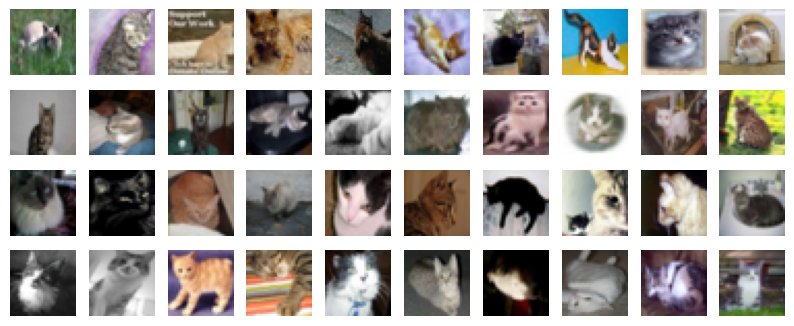

In [21]:
#test code 之后记得改回来后删除！

load("hssp.sage")
load('multi-dim-hssp.sage')
load("extendhssp.sage")
load("statistical.sage")


generated_vector, modulus = generate_vector(sampling_number, relu_data, batch_size, random_sampling, random_generation, rate, sample_figure_length)


full_image = matrixed_image(original_image, batch_size)


processed_image = process_image(full_image, sample_figure_length)


#reconstructed_vector,generated_vector_nonsingular = NS_attack_original(batch_size, modulus, processed_image, generated_vector, sample_figure_length)


#reconstructed_vector,generated_vector_nonsingular = NS_attack(batch_size, modulus, processed_image, generated_vector, sample_figure_length)

#reconstructed_vector,generated_vector_nonsingular = Multi_attack(batch_size, modulus, processed_image, generated_vector, sample_figure_length)

reconstructed_vector,generated_vector_nonsingular = Statistical_attack(batch_size, modulus, processed_image, generated_vector, sample_figure_length)

# if reconstructed_vector == 0:
#     print("wrong")
# elif reconstructed_vector == 1:
#     print("non integer")

matrixB = generated_vector_nonsingular * full_image % modulus



image_reconstruction(reconstructed_vector, matrixB, batch_size)


 Original input images:


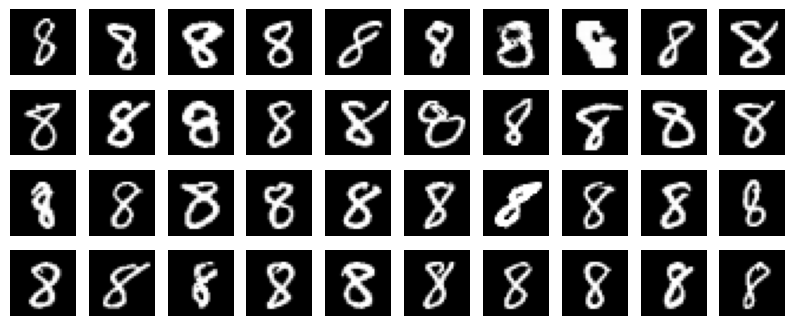

In [27]:
#图片打印测试

import numpy as np
import matplotlib.pyplot as plt
R=np.load('/Users/jichanglong/Desktop/hssp_new/expdata/true_fl/truefl_mnist_8/images_epoch_1_batch_0.npy')
#print(R)
#R=np.random.shuffle(R)
#print(R[0,:])
n=40
#idx=matrix()

import matplotlib.pyplot as plt
num_col = 10
num_row = int(n/num_col)
num_samples = num_row*num_col
shape= (28,28)
fig, axes = plt.subplots(num_row, num_col, figsize=(1.*num_col,1.*num_row))
print('\n Original input images:')
for i, ax in enumerate(axes.flat):
      ax.set_axis_off()
      ax.imshow(R[i].reshape(shape), cmap='gray') 
plt.savefig('./figure/true/mnist_8_original.pdf')  # 保存为 PDF
plt.savefig('./figure/true/mnist_8_original.png', dpi=600)  # 保存为 PNG，指定分辨率为300 dpi

In [30]:
load('multi-dim-hssp.sage')
load("hssp.sage")
load("extendhssp.sage")

def generate_vector(sampling_number, data, batch_size, random_sampling = False, random_generation = False, rate = 0.5, sample_figure_length = 10):
    data = np.load(data)
    if random_generation == False:
        D=matrix(ZZ,data)
        e=vector(ones_matrix(1,batch_size))
        n = batch_size
        m0 = sampling_number
        freqD=(n+1)*[0]

        for x in e*D: 
            #print(x)
            freqD[x]+=1

        freqU=[binomial(n,i)/2.**n for i in range(n+1)]

        c=dict()
        for x in D.T: 
            h=x*e
            if h in c.keys(): c[h]+=[x]
            else: c[h]=[x]
        sampleSize=[int(m0*f) for f in freqU]
        
        if random_sampling == False:
            
            L = []
    # 假设 L 是一个列表，n 和 sampleSize 已经定义
            for i in range(n + 1):
        # 先检查键 i 是否存在于字典 c 中
                if i in c:
            # 如果存在，再检查 c[i] 的长度是否大于等于 sampleSize[i]
                    if len(c[i]) >= sampleSize[i]:
                # 如果是，正常采样
                        L += random.sample(c[i], k=sampleSize[i])
                    else:
                # 如果不是，取所有元素
                        L += c[i]
        else:
            L = []
            all_elements = []
            for key, value in c.items():
                all_elements.extend(value)
    # 然后，从这个列表中随机选取100个元素，前提是列表长度至少为100
            L += random.sample(all_elements, sampling_number)
        while True:
            random.shuffle(L)
            newX=matrix(ZZ,L)
            if newX.rank()==batch_size: break 
        
        freqnewX=(n+1)*[0]
        for x in newX*e: freqnewX[x]+=1
        G1=bar_chart(freqD, legend_label='frequency hw input')
        G2=bar_chart(freqnewX, legend_label='frequency hw output')
        G3=bar_chart(freqU, legend_label='frequency hw uniform')
        #for g in [G1,G2]: g.show()
        
        
    else:
        np.random.seed(0)

        size = (sampling_number, batch_size)
        p = [rate , 1 - rate]  # 0和1出现的概率
        #print(p)
    # 使用numpy的random.choice来生成矩阵
        random_matrix = np.random.choice([0, 1], size=size, p=p)
        
        
        while True:
            np.random.shuffle(random_matrix)
            newX=matrix(ZZ,random_matrix)
            if newX.rank()==batch_size: break 
        
        
    m=(newX.dimensions()[0])//batch_size*batch_size
        
    l = sample_figure_length
        
    x0,A,dummyX,dummyB=genParams_mat(m=m,l=batch_size)

    Y=newX[:m]   
   
    Y = matrix(ZZ,Y)
    #print(Y.dimensions())
    return Y, x0
#这里需要修改，因为图片的格式不一样了

def matrixed_image(image, batch_size):
    alp = np.load(image)
    
    # 假设加载的数据已经是归一化后的图像数据，形状为 (batch_size, 1, 28, 28)
    # 将像素值从[-1, 1]转换到[0, 1]
    alp = (alp + 1.0) / 2.0
    
    # 将像素值缩放到[0, 255]的范围
    alp = (alp * 255.0).astype(np.uint8)
    
    # 由于MNIST图像是单通道的，需要调整维度转换逻辑
    # 移除通道维度，转换成 (batch_size, 28, 28)
    alp = np.squeeze(alp, axis=1)
    
    # 将图像数据重排成一维向量 (batch_size, 784)
    alp = alp.reshape(batch_size, -1)
    
    # 使用Sage的矩阵构造函数创建整数矩阵
    Aifull = matrix(ZZ, alp)
    
    return Aifull

import numpy as np
from sklearn.decomposition import FastICA
import math
from time import time
import numpy as np
import random
import matplotlib.pyplot as plt
import json


def NS_attack_original(batch_size, modulus, processed_image, generated_vector, sample_figure_length):
    n = batch_size
    
    x0 = modulus
    
    Ai = processed_image
    
    Y = generated_vector
    
    m = Y.dimensions()[0]
    
    l = sample_figure_length
    
    while True:
        rows_list = list(Y.rows())
        # 随机打乱行顺序
        random.shuffle(rows_list)
        # 将打乱后的行列表转换回矩阵
        Y = matrix(rows_list)
        Bi = Y * Ai % x0
        s = Matrix(Integers(x0), Bi[:l, :l]).determinant()
        if s != 0:
            break
    
    #kei,tt1,tt10,tt1O=Step1_Mat(n,x0,Ai,Y,Bi,m)
    kei, tt1, tt10, tt1O = Step1_original(n, -1, x0, Ai, Y, Bi, m)

    MBi,beta =Step2_BKZ(kei,1,n,m,x0,Y,1,1,-1)
    
    return MBi,Y

def Multi_attack(batch_size, modulus, processed_image, generated_vector, sample_figure_length):
    n = batch_size
    
    x0 = modulus
    
    Ai = processed_image
    
    Y = generated_vector
    
    m = Y.dimensions()[0]
    
    l = sample_figure_length
    
    while True:
        rows_list = list(Y.rows())
        random.shuffle(rows_list)
        Y = matrix(rows_list)
        Bi = Y * Ai % x0
        s = Matrix(Integers(x0), Bi[:l, :l]).determinant()
        if s != 0:
            break
    
    MO,tt1,tt10,tt1O= Step1_Mat(n,x0,Ai,Y,Bi,m) 
    
    tei, tef, tt2,nrafound,MB,NFound,Coef = eigen_mat(n,-1,MO,x0, Ai,Y,Bi,m)
    
    MB = matrix(ZZ,MB)
    
    return MB,Y

def ICA(X, B=1, n=16, kappa=-1, exn=0):
    t = time()
    X = np.asarray(X)
    ncomp, sample = X.shape
    #print(X.shape)
    ica = FastICA(n_components=ncomp, fun='cube')
    S_ = ica.fit_transform(X.T)
    A_ = ica.mixing_
    # assert np.allclose(X.T, np.dot(S_, A_.T) + ica.mean_)

    # we want to remove the mean
    #print(A_)
    #print(np.linalg.inv(A_.T).shape)
    s0 = np.dot(ica.mean_, np.linalg.inv(A_.T))
    S_ += s0

    # assert np.allclose(X, np.dot(A_,S_.T))  # now the mean is 0

    # we want that the components of S_ are positive
    # if the average of a column of S_ is negative, we take the opposite
    Sm = np.sign(np.average(S_, axis=0))
    S_ *= Sm
    A_ *= Sm

    # assert np.allclose(X, np.dot(A_,S_.T))

    # we want that the components of S_ are 0 or 1
    # If all the components of S_ are 0 or 1, the standard deviation will be 1/2
    # If the components are uniformly distributed between 0 and B, the standard deviation is
    # sqrt(B(B+2)/12)
    # So we divide the components of S_ by std/sqrt(B(B+2)/12), where std is computed column by column
    if kappa == -1 and exn == 0:
        exn = math.sqrt(B * (B + 2) / 12.)
    elif exn == 0:
        exn = math.sqrt((2 * B + 1) * (B + 1) * kappa / (n * 6.) - (kappa * (B + 1) / (2 * n)) ** 2)  # exn=math.sqrt((2*B+1)*(B+1)*kappa/(n*6.))

    st = S_.std(axis=0) / exn
    S_ /= st
    A_ *= st

    # print " ICA.py %.2f" %(time()-t),
    # assert np.allclose(X, np.dot(A_,S_.T))
    np.save('./ICA/A_.npy',A_)
    
    np.save('./ICA/S.npy',S_.T)

    #return A_, S_.T
    return

def Statistical_attack(batch_size, modulus, processed_image, generated_vector, sample_figure_length):
    n = batch_size
    
    x0 = modulus
    
    Ai = processed_image
    
    Y = generated_vector
    
    m = Y.dimensions()[0]
    
    l = sample_figure_length
    
    while True:
        rows_list = list(Y.rows())
        random.shuffle(rows_list)
        Y = matrix(rows_list)
        Bi = Y * Ai % x0
        s = Matrix(Integers(x0), Bi[:l, :l]).determinant()
        if s != 0:
            break
            
    
    
    MO,tt1,tt10,tt1O= Step1(n,-1,x0,Ai,Y,Bi,m, BKZ=True)
    
    print ("\nStatistical Attack")     
    
    MOn,MO=statistical_1(MO,n,m,x0,Y,Ai ,Bi, -1)
    
    
    #print(MOn)
    #print(len(MOn))
    #print(MOn[0].shape)
    ICA(MOn)
    
    tica, tt2, nrafound, MB,NFound,Coef = statistical_2_mat(MOn,MO,n,m,x0,Y,Ai,Bi,-1)
    
    if MB == 0:
        return 0,0
    
    if not np.all(np.floor(MB) == MB):
        return 1,1
    MB = matrix(ZZ,MB)
    

    return MB,Y



def process_image(Aifull, sample_figure_length):
    
    l = sample_figure_length
    someA=random.sample(Aifull.columns(),80)
    #print(matrix(ZZ,someA).T)
    data = someA
    # 计算列表中每个元组中0的数量，并附带原索引位置
    count_zeros = [(sum(1 for x in sublist if x == 0), i) for i, sublist in enumerate(data)]

# 根据0的数量对元组进行排序
    count_zeros.sort()

# 获取0元素最少的10个元组的索引
    selected_indices = [idx for _, idx in count_zeros[:l]]

# 使用这些索引来生成新的列表
    new_list = [data[i] for i in selected_indices]
    someA = new_list
   # print(type(someA))
    #print(someA)
    Ai=matrix(ZZ,someA).T
    
    return Ai


def image_reconstruction(MBi, matrixB, batch_size):
    
    res_alpha = np.linalg.lstsq(MBi.T, matrixB, rcond=None)[0]

    # print(res_alpha.shape)
    # print('Reconstructed input using NS attack:')
    num_col = 10
    num_row = int(n/num_col)
    #num_samples = num_row * num_col
    shape = (28,28)
    fig, axes = plt.subplots(num_row, num_col, figsize=(1. * num_col, 1. * num_row))
    for i, ax in enumerate(axes.flat):
        ax.set_axis_off()
        ax.imshow(res_alpha[i].reshape(shape).astype(np.uint8), cmap='gray')
    plt.savefig('./figure/true/mnist_8_multi.pdf')  # 保存为 PDF
    plt.savefig('./figure/true/mnist_8_multi.png', dpi=600)  # 保存为 PNG，指定分辨率为300 dpi


40
Building M 
here 1
here 2
here 3
here 4
Step 1
  LLL:0.4
  Sred1:0.4
  Sred2:2.2
  #ortho vecs= 960 out of 960
  Kernel LLL: 0.1
  Total Step 1: 3.3

Statistical Attack
Step 2-ICA:  roundA
 time LLL= 0.0357789999999909 mathNbits= 1
statistical_2_mat here
time Ica_A:  0.00045800000000895125
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  1  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

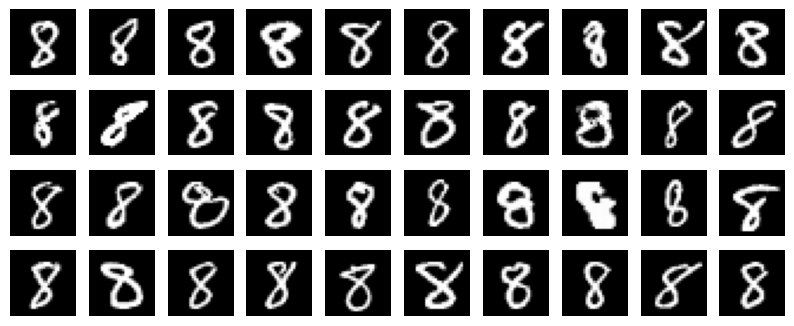

In [31]:
conf_path = './utils/conf.json'

    # 读取配置文件
with open(conf_path, 'r') as f:
    conf = json.load(f)
    
size =40
#这是20的

relu_data = f"/Users/jichanglong/Desktop/hssp_new/expdata/true_fl/truefl_mnist_8/images_epoch_1_batch_0.npy"

original_image = f"/Users/jichanglong/Desktop/hssp_new/expdata/true_fl/truefl_mnist_8/images_epoch_1_batch_0.npy"

#reludata = f"/Users/jichanglong/Desktop/hssp_new/expdata/mnist/eight/batch_{size}/gradients_fc1_relu_binary_epoch_0_batch_0.npy"

#original_image = f"/Users/jichanglong/Desktop/hssp_new/expdata/mnist/eight/batch_{size}/images_epoch_0_batch_0.npy"

sampling_number=1000

batch_size=conf["batch_size"]


batch_size=size
print(batch_size)
random_sampling = True

random_generation = True

rate = 0.5

sample_figure_length = 15

test_rounds = 50

#test code 之后记得改回来后删除！

load("hssp.sage")
load('multi-dim-hssp.sage')
load("extendhssp.sage")
load("statistical.sage")


generated_vector, modulus = generate_vector(sampling_number, relu_data, batch_size, random_sampling, random_generation, rate, sample_figure_length)


full_image = matrixed_image(original_image, batch_size)


processed_image = process_image(full_image, sample_figure_length)


#reconstructed_vector,generated_vector_nonsingular = NS_attack_original(batch_size, modulus, processed_image, generated_vector, sample_figure_length)


#reconstructed_vector,generated_vector_nonsingular = NS_attack(batch_size, modulus, processed_image, generated_vector, sample_figure_length)

#reconstructed_vector,generated_vector_nonsingular = Multi_attack(batch_size, modulus, processed_image, generated_vector, sample_figure_length)

reconstructed_vector,generated_vector_nonsingular = Statistical_attack(batch_size, modulus, processed_image, generated_vector, sample_figure_length)

# if reconstructed_vector == 0:
#     print("wrong")
# elif reconstructed_vector == 1:
#     print("non integer")

matrixB = generated_vector_nonsingular * full_image % modulus



image_reconstruction(reconstructed_vector, matrixB, batch_size)